# Module 04: Advection Dominated Systems Assignment

## Overview and Requirements

___DISASTER!___ An earthquake has resulted in a partial meltdown of a nuclear reactor and the contamination of that reactor's cooling water tanks. The reactor automatically scrammed and the reactor hall was safe enough that the fuel rods were removed, but not before a significant leak of radioactive Cesium into the water stored in the tanks. Cs-137 is highly soluble in water and so the whole tank is effectively uniformly contaminated. What's worse, the earthquake also ruptured the cooling water tanks and contaminated water is now leaking into the aquifer. The location of the rupture is such that it is too dangerous to repair. 

Your job as a consultant is to conduct a "worst case" scenario modeling study in which the tank will continue to drain contaminated water into the aquifer at a constant rate of 0.05% of its volume per year. The aquifer is an unconfined aquifer that has a saturated hydraulic conductivity ($K_s$) of 15.0 cm/day and a constant regional head gradient $\partial h/\partial t$ of 30.0 ft/mile. 

Using your trusy advection-dominated code your wrote as a graduate student at Boise State, you know you can simply modify the boundary conditions to your model to examine the impact. Your solution notebook you turn in should have code that produces the following plots:

* The concentration of the contaminant of the aquifer at the contamination site 
* Concentration profiles (concentration vs. distance) at every 50th time step of the simulation 
* The plot showing the evolution of concentration as a function of both distance from the contamination site and time
* The breakthrough curve (concentration vs. time) at a location x = 1500 m

Answer the following questions:
* What time step did you have to select to get the Courant number as close to 1.0 as possible? 
* If you were to have to describe what was going to happen to the water quality at the town located 1.5 km from the contamination site, how would you describe in words how the water quality will behave in the future? 
* If concentrations below 0.05 GBq/g are considered safe for drinking water quallity, at the town 1.5 km away from the contamination site, how many years in the future will it take the contamination plume to arrive? And how long will the water be unusable? 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

dx = 5.0  # Spatial interval [m] - DON'T CHANGE
dt = 5.0/0.312  # Time step [yr]  #5.0/0.311

# Fraction of initial tank volume lost each year [yr-1]
k_tank = 0.0005 

xmin = 0.0 # Origin: Contamination site
xmax = 4000.0 # Edge of the domain

t0 = 0.0 # Time that the tank broke
tf = 10000.0 # End of simulation time

Ks = 15.0 # Saturated hydraylic conductivity [cm/day]
dhdx = 30.0 # Regional piezometric gradient [ft/mi]

Ks = Ks/100.0*365.25 # Converting Ks from [cm/day] to [m/yr]
dhdx = dhdx*(1/5280.0)

In [2]:
q = Ks*dhdx

print('The Darcy velocity is ' + '{:.3f}'.format(q) + ' [m/yr]')

The Darcy velocity is 0.311 [m/yr]


In [3]:
x = np.arange(xmin+dx/2, xmax, dx)
Nx = x.size

print('The number of cells is: Nx = ' + str(Nx))

The number of cells is: Nx = 800


In [4]:
t = np.arange(t0,tf+dt,dt)
Nt = t.size
print('The number of time steps: Nt = ' + str(Nt))

The number of time steps: Nt = 625


In [5]:
Courant = q*(dt/dx)

print('The Courant number is ' + '{:.3f}'.format(Courant)+'. The optimal number is 1 to avoid numerical diffusion. Consider changing dt')

The Courant number is 0.998. The optimal number is 1 to avoid numerical diffusion. Consider changing dt


### Setup Initial and Boundary Conditions

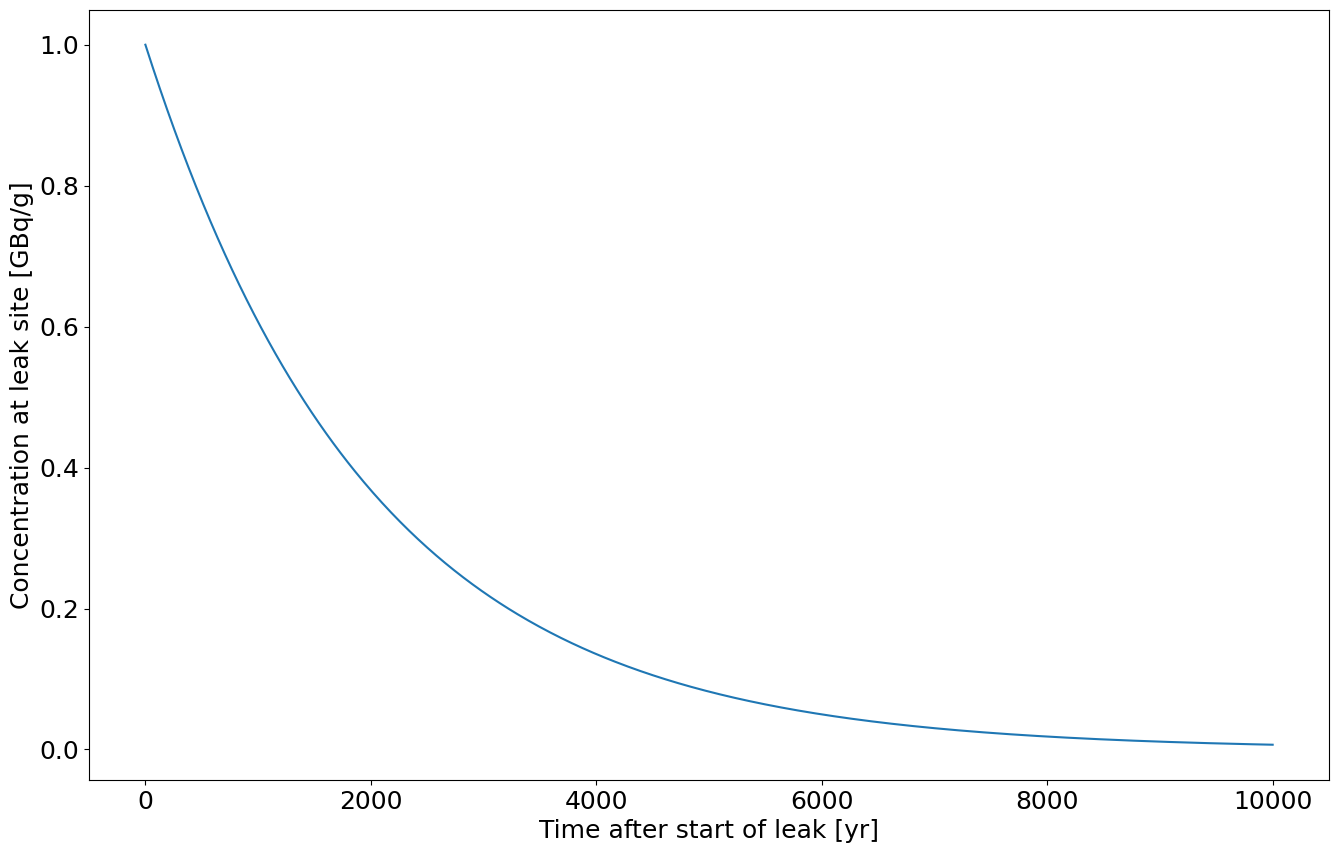

In [6]:
# Initial condition: concentration is 0 GBq/g everywhere except at x = 0,
# where it is 1 Bq/g
c0 = np.zeros((Nx,1))
c0[0] = 1

# Boundary condition: concentration decreases at a rate of k_tank [yr-1]
csource = np.zeros(Nt)
csource[0] = 1.
for i in range(1,Nt):
    #csource[i] = 1 - t[i]*k_tank
    csource[i] = np.exp(-k_tank*t[i])
    if csource[i]<= 0:
        csource[i] = 0
        break

plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 18})
plt.plot(t,csource)
plt.xlabel('Time after start of leak [yr]')
plt.ylabel('Concentration at leak site [GBq/g]')
plt.show()

### Preallocate Container for Solution

In [7]:
C = np.zeros((Nx,Nt))


### Compute Solution

In [8]:
for i in np.arange(Nt):
    
    # Get initial conditions
    if (i==0):
        Cprev = c0
    else:
        Cprev = C[:,i-1]
    
    Cnext = np.zeros((Nx))
    
    for j in np.arange(Nx):
        
        if (j==0):
            Cnext[0] = csource[i]
            
        else:
            Cnext[j] = Cprev[j] + q*(dt/dx)*(Cprev[j-1] - Cprev[j])
    C[:,i] = Cnext

C:\Users\ZIHAOZHANG\AppData\Local\Temp\ipykernel_11560\2180912209.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cnext[j] = Cprev[j] + q*(dt/dx)*(Cprev[j-1] - Cprev[j])


### Plot solutions

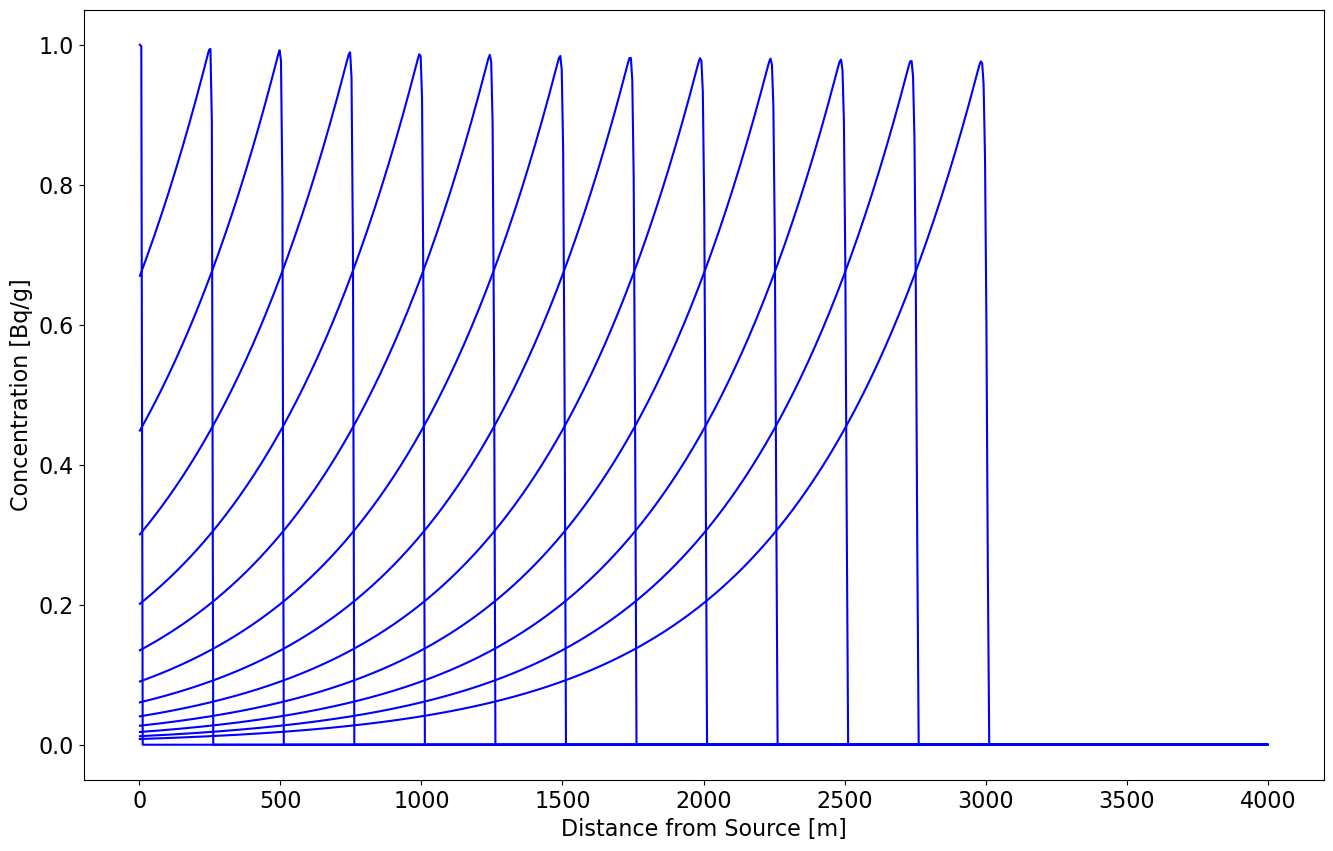

In [9]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))

for p in np.arange(0,Nt,50):
    plt.plot(x,C[:,p],'b')
plt.ylabel('Concentration [Bq/g]')
plt.xlabel('Distance from Source [m]')
plt.show()

Text(0, 0.5, 'Time [years]')

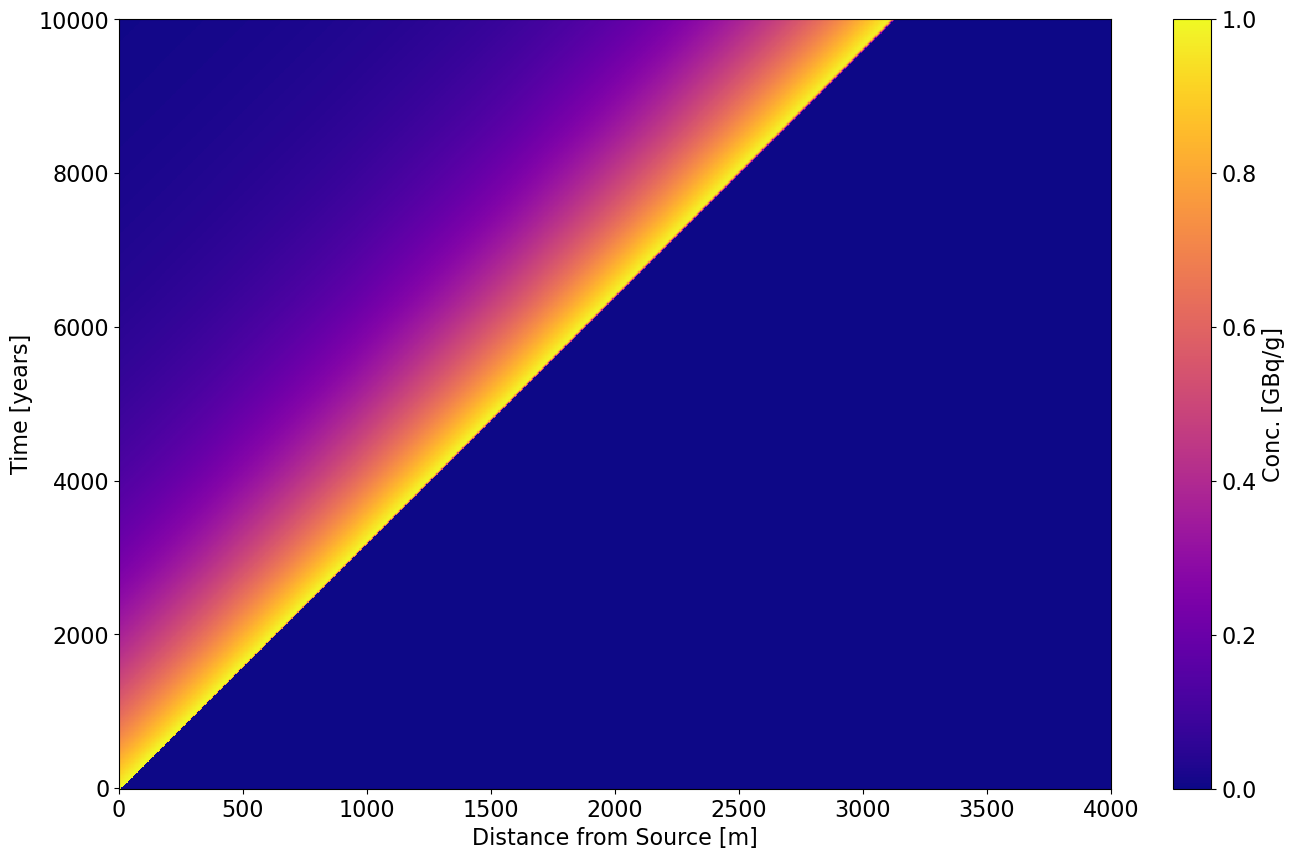

In [10]:
xx,tt = np.meshgrid(t,x)

plt.figure(figsize=(16,10))

plt.pcolormesh(tt,xx,C,cmap='plasma') 
plt.colorbar(label='Conc. [GBq/g]')
plt.xlabel('Distance from Source [m]')
plt.ylabel('Time [years]')


In [11]:
for i in range(Nx):
    if x[i]<=1500. and x[i+1]>1500.:
        index = i
        print(x[i],x[i+1])
        break

1497.5 1502.5


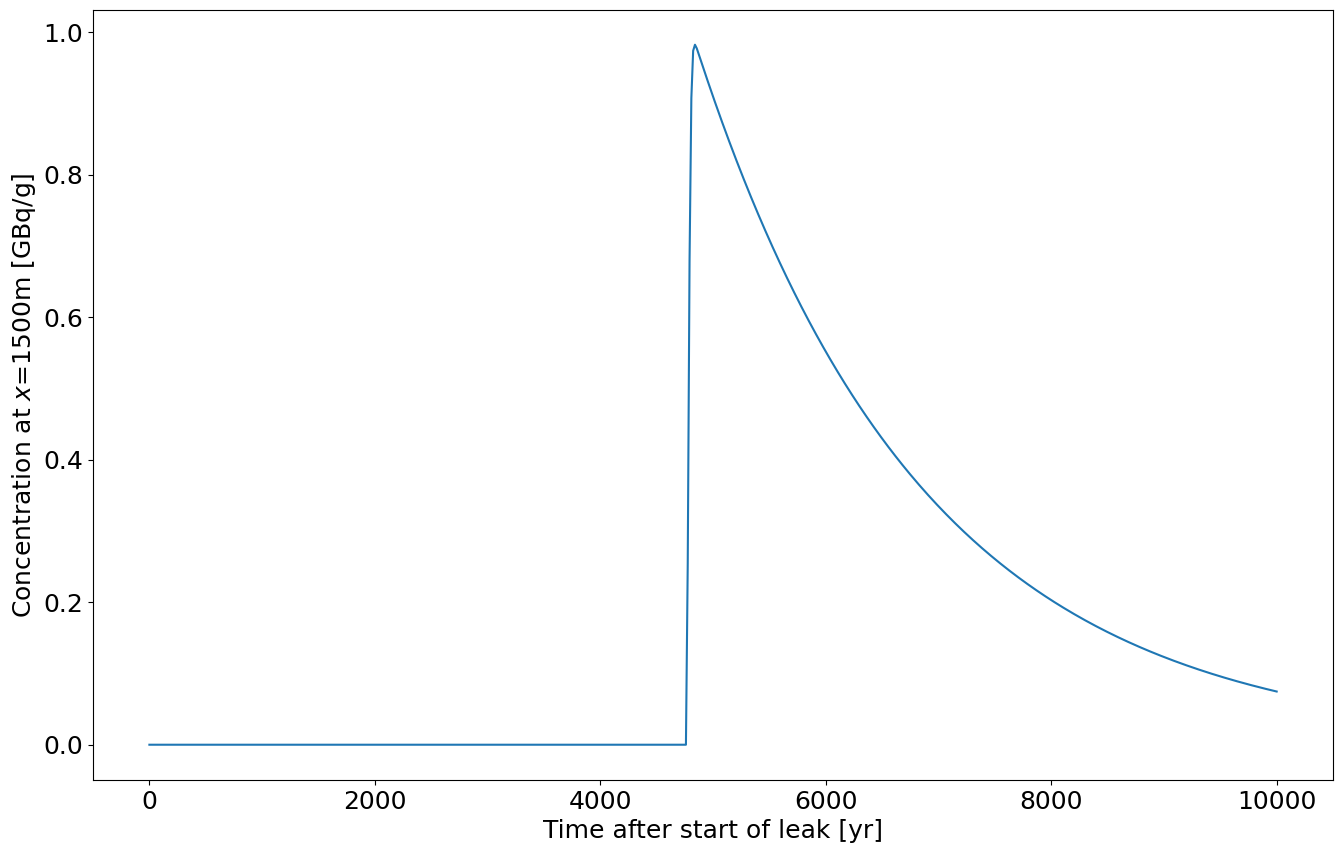

In [12]:
C_1500 = (C[index, :]+C[index+1, :])/2
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 18})
plt.plot(t,C_1500)
plt.xlabel('Time after start of leak [yr]')
plt.ylabel('Concentration at $x$=1500m [GBq/g]')
plt.show()

## Questions
* I choose time step as $\frac{5.0}{0.312}=16.025$

* I would say the water quality will not be affected by the pollution within 4775 years after start of leak, but something has to be done beforehand because after 4775 years, the pollution concentration will appear due to the advection and will produce its peak pollution concentration, 1 [GBq/g]. After it reaches its peak, it will decrease gradually and will be below 0.2 [GBq/g] by 10000 years after start of leak.

* The pollution will arive in 4775.64 years after the start of the leak and water will be unusable for 3269.23 years after the arrival of pollution  

In [16]:
found_index1 = False  
found_index2 = False  
for i in range(Nt):
    if not found_index1 and C_1500[i] > 0.2:
        index1 = i
        found_index1 = True 
    if found_index1 and not found_index2 and C_1500[i] < 0.2:
        index2 = i
        break  
print(f'The pollution will arive in {t[index1]:6.2f} years after the start of the leak and water will be unusable for {t[index2]-t[index1]:6.2f} years')

The pollution will arive in 4775.64 years after the start of the leak and water will be unusable for 3269.23 years
